Synchrony exit triggered at t = 373.91 s


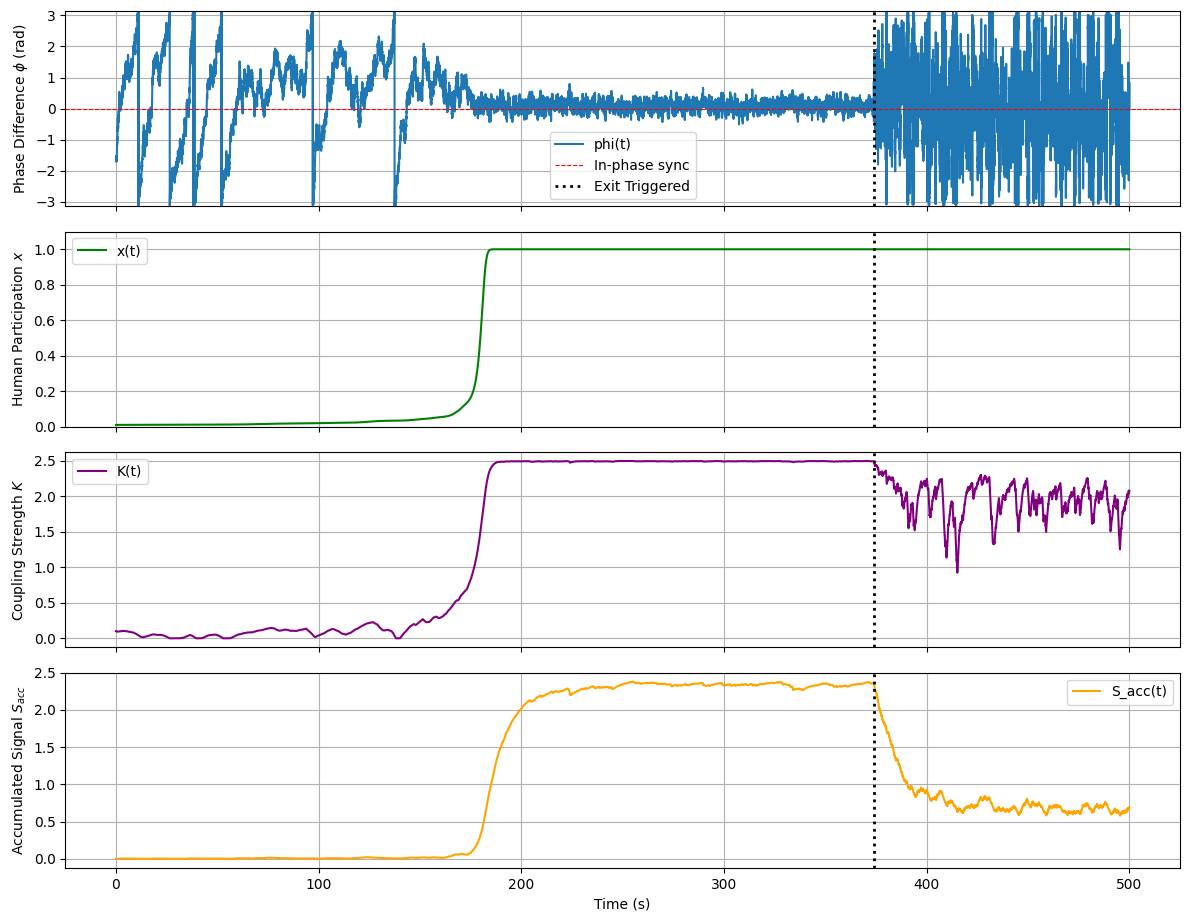

In [3]:
import numpy as np
import matplotlib.pyplot as plt

delta_w = 0.4      # Difference in intrinsic frequencies (rad/s)
K_max = 3.0        # Maximum coupling strength (rad/s)
beta = 0.5         # Growth rate for K
delta = 0.1        # Decay rate for K 
r = 1.0            # Growth rate for x 
alpha = 1.0        # Modulation strength on x dynamics (dimensionless)
G = 1.0            # Gain for the accumulated signal
thresh_cos = 0.75  # Threshold for the cosine term (dimensionless)
tau_sacc = 10.0    # Time constant for the decay of S_acc (s)

T_sync_duration = 150.0       # Required duration of synchrony to trigger exit (s)
noise_strength_base = 0.5     # Standard noise level during interaction
noise_strength_high = 3.0     # High noise level to break synchrony lock

dt = 0.01          # Time step (s)
T = 500            # Total simulation time (s)
n_steps = int(T / dt)
time = np.linspace(0, T, n_steps)

phi = np.zeros(n_steps)
x = np.zeros(n_steps)
K = np.zeros(n_steps)
S_acc = np.zeros(n_steps)

phi[0] = np.pi * (2 * np.random.rand() - 1)
x[0] = 0.01
K[0] = 0.1
S_acc[0] = 0.0

sync_time_accumulator = 0.0
exit_triggered = False
exit_time = -1
current_noise_strength = noise_strength_base

for t in range(n_steps - 1):
    if np.cos(phi[t]) > thresh_cos:
        sync_time_accumulator += dt
    else:
        sync_time_accumulator = 0

    if sync_time_accumulator >= T_sync_duration and not exit_triggered:
        exit_triggered = True
        current_noise_strength = noise_strength_high
        exit_time = time[t]
        print(f"Synchrony exit triggered at t = {exit_time:.2f} s")

    dphi_dt = delta_w - 2 * K[t] * np.sin(phi[t])
    dx_dt = r * S_acc[t] * x[t] * (1 - x[t]) * (1 + alpha * np.cos(phi[t]))
    dK_dt = beta * x[t] * np.cos(phi[t]) * (K_max - K[t]) - delta * K[t]
    max_term = np.maximum(0, np.cos(phi[t]) - thresh_cos)
    dS_acc_dt = G * max_term * x[t] - (S_acc[t] / tau_sacc)

    noise = current_noise_strength * np.random.randn() * np.sqrt(dt)
    phi[t+1] = phi[t] + dt * dphi_dt + noise
    phi[t+1] = (phi[t+1] + np.pi) % (2 * np.pi) - np.pi
        
    x[t+1] = x[t] + dt * dx_dt
    K[t+1] = K[t] + dt * dK_dt
    S_acc[t+1] = S_acc[t] + dt * dS_acc_dt
    
    x[t+1] = np.clip(x[t+1], 0, 1)
    K[t+1] = np.clip(K[t+1], 0, K_max)
    S_acc[t+1] = np.maximum(0, S_acc[t+1])

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(time, phi, label='phi(t)')
axs[0].set_ylabel('Phase Difference $\phi$ (rad)')
axs[0].set_ylim(-np.pi, np.pi)
axs[0].axhline(0, color='r', linestyle='--', linewidth=0.8, label='In-phase sync')
if exit_triggered:
    axs[0].axvline(exit_time, color='k', linestyle=':', linewidth=2, label='Exit Triggered')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time, x, label='x(t)', color='g')
axs[1].set_ylabel('Human Participation $x$')
axs[1].set_ylim(0, 1.1)
if exit_triggered:
    axs[1].axvline(exit_time, color='k', linestyle=':', linewidth=2)
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time, K, label='K(t)', color='purple')
axs[2].set_ylabel('Coupling Strength $K$')
if exit_triggered:
    axs[2].axvline(exit_time, color='k', linestyle=':', linewidth=2)
axs[2].legend()
axs[2].grid(True)

axs[3].plot(time, S_acc, label='S_acc(t)', color='orange')
axs[3].set_ylabel('Accumulated Signal $S_{acc}$')
axs[3].set_xlabel('Time (s)')
if exit_triggered:
    axs[3].axvline(exit_time, color='k', linestyle=':', linewidth=2)
axs[3].legend()
axs[3].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])